In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))
test_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset((train_set, test_set)),
    batch_size=64,
    shuffle=True)

In [4]:
x = np.array(train_set.train_data)

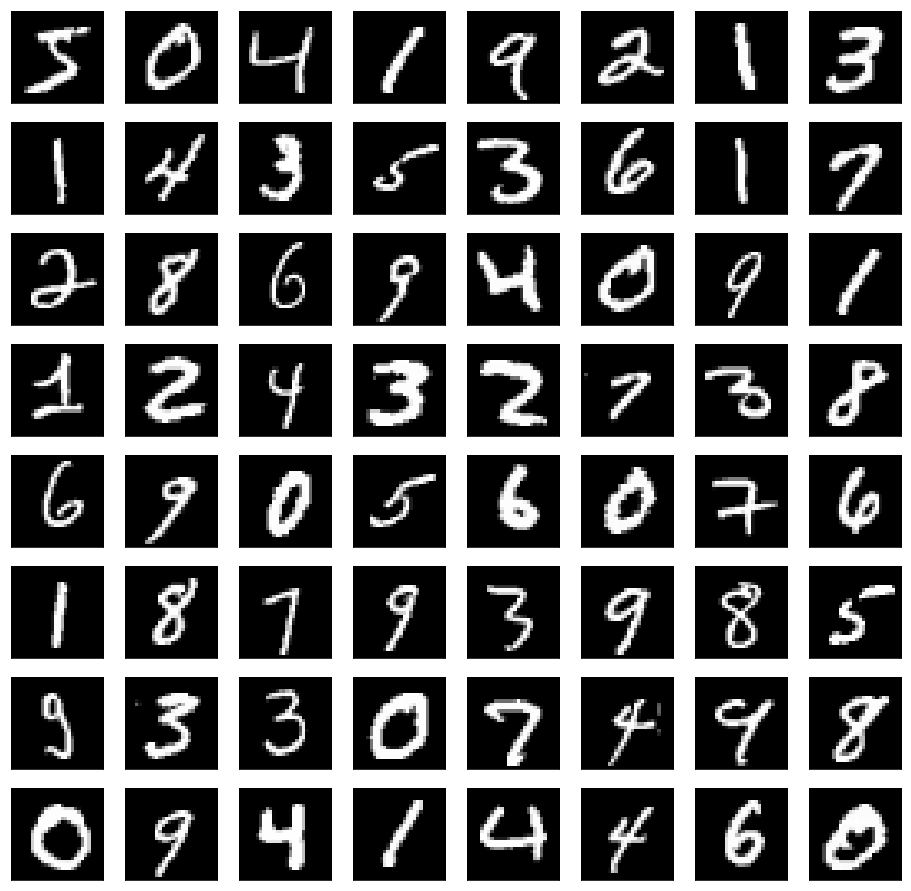

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('Visualization of loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('Visualization of accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
class GAN_:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.loss = torch.nn.functional.binary_cross_entropy

        self.g = None
        self.d = None

    def fit(self, data_loader, epochs):
        self.g.to(self.device)
        self.d.to(self.device)
        history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
        for epoch in range(1, epochs + 1):
            self.g.train()
            self.d.train()
            start_time = time.time()
            g_loss, d_loss, d_acc = 0, 0, 0
            for real_imgs, _ in data_loader:
                real = torch.Tensor(real_imgs.size(0), 1).fill_(0.9).to(self.device)
                fake = torch.Tensor(real_imgs.size(0), 1).fill_(0.0).to(self.device)
                real_imgs = real_imgs.to(self.device)
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (real_imgs.size(0), 100))).to(self.device))
                # Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Train generator
                self.g.optimizer.zero_grad()
                g_loss_ = self.loss(self.d(fake_imgs), real)
                g_loss_.backward()
                self.g.optimizer.step()# Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Calculate metrics for batch
                g_loss += float(g_loss_) * len(real_imgs)
                d_loss += float(d_loss_) * len(real_imgs)
                d_acc += int((real_out >= 0.5).sum()) + int((fake_out < 0.5).sum())
            # Calculate metrics for epoch
            g_loss /= len(data_loader.dataset)
            d_loss /= len(data_loader.dataset)
            d_acc /= 2 * len(data_loader.dataset)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['g_loss'].append(g_loss)
            history['d_loss'].append(d_loss)
            history['d_acc'].append(d_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')

            if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (24, 100))).to(self.device)).detach().cpu()
                plt.figure(figsize=(16, 6))
                for i in range(24):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(fake_imgs[i], cmap=plt.cm.gray)
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

        return history

In [8]:
class GAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(100, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(256, momentum=0.8),
                    torch.nn.Linear(256, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(512, momentum=0.8),
                    torch.nn.Linear(512, 1024),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(1024, momentum=0.8),
                    torch.nn.Linear(1024, 784),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(784, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.4),
                    torch.nn.Linear(512, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.4),
                    torch.nn.Linear(256, 1),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), -1)
                for layer in self.layers:
                    x = layer(x)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [9]:
model = GAN()

[ 1/80] 15.4s - g_loss: 1.2725 - d_loss: 0.4925 - d_acc: 0.8001


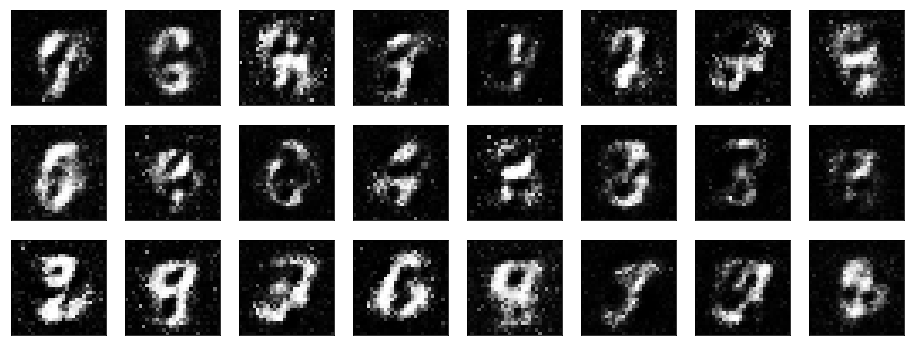

[ 2/80] 15.6s - g_loss: 1.2514 - d_loss: 0.5269 - d_acc: 0.7687
[ 3/80] 14.9s - g_loss: 1.1532 - d_loss: 0.5556 - d_acc: 0.7381
[ 4/80] 14.4s - g_loss: 1.0656 - d_loss: 0.5866 - d_acc: 0.7019
[ 5/80] 14.2s - g_loss: 1.0128 - d_loss: 0.6081 - d_acc: 0.6748
[ 6/80] 14.4s - g_loss: 0.9861 - d_loss: 0.6195 - d_acc: 0.6607
[ 7/80] 14.8s - g_loss: 0.9567 - d_loss: 0.6279 - d_acc: 0.6491
[ 8/80] 14.5s - g_loss: 0.9385 - d_loss: 0.6341 - d_acc: 0.6390
[ 9/80] 14.2s - g_loss: 0.9284 - d_loss: 0.6394 - d_acc: 0.6304
[10/80] 14.5s - g_loss: 0.9123 - d_loss: 0.6438 - d_acc: 0.6238
[11/80] 14.5s - g_loss: 0.9032 - d_loss: 0.6457 - d_acc: 0.6208
[12/80] 14.3s - g_loss: 0.8974 - d_loss: 0.6480 - d_acc: 0.6154
[13/80] 14.4s - g_loss: 0.8937 - d_loss: 0.6481 - d_acc: 0.6149
[14/80] 14.5s - g_loss: 0.8874 - d_loss: 0.6500 - d_acc: 0.6121
[15/80] 14.6s - g_loss: 0.8828 - d_loss: 0.6515 - d_acc: 0.6085
[16/80] 14.5s - g_loss: 0.8796 - d_loss: 0.6523 - d_acc: 0.6088
[17/80] 14.5s - g_loss: 0.8768 - d_loss:

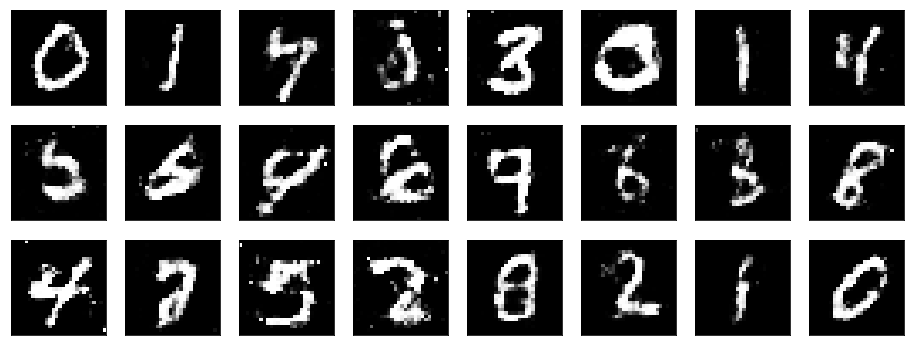

[21/80] 14.9s - g_loss: 0.8672 - d_loss: 0.6562 - d_acc: 0.6001
[22/80] 14.5s - g_loss: 0.8659 - d_loss: 0.6566 - d_acc: 0.6001
[23/80] 14.9s - g_loss: 0.8652 - d_loss: 0.6573 - d_acc: 0.5986
[24/80] 14.8s - g_loss: 0.8649 - d_loss: 0.6579 - d_acc: 0.5977
[25/80] 14.5s - g_loss: 0.8610 - d_loss: 0.6591 - d_acc: 0.5943
[26/80] 14.6s - g_loss: 0.8609 - d_loss: 0.6588 - d_acc: 0.5953
[27/80] 15.0s - g_loss: 0.8571 - d_loss: 0.6601 - d_acc: 0.5928
[28/80] 15.0s - g_loss: 0.8567 - d_loss: 0.6599 - d_acc: 0.5935
[29/80] 14.6s - g_loss: 0.8580 - d_loss: 0.6597 - d_acc: 0.5918
[30/80] 14.7s - g_loss: 0.8566 - d_loss: 0.6606 - d_acc: 0.5915
[31/80] 15.1s - g_loss: 0.8534 - d_loss: 0.6608 - d_acc: 0.5912
[32/80] 14.5s - g_loss: 0.8531 - d_loss: 0.6610 - d_acc: 0.5909
[33/80] 14.5s - g_loss: 0.8535 - d_loss: 0.6615 - d_acc: 0.5888
[34/80] 14.5s - g_loss: 0.8507 - d_loss: 0.6622 - d_acc: 0.5877
[35/80] 14.6s - g_loss: 0.8535 - d_loss: 0.6618 - d_acc: 0.5898
[36/80] 14.6s - g_loss: 0.8523 - d_loss:

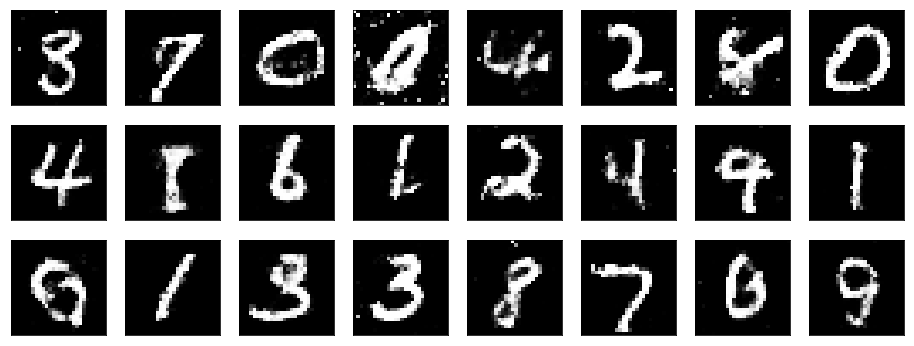

[41/80] 15.1s - g_loss: 0.8479 - d_loss: 0.6636 - d_acc: 0.5868
[42/80] 14.7s - g_loss: 0.8505 - d_loss: 0.6625 - d_acc: 0.5875
[43/80] 14.6s - g_loss: 0.8505 - d_loss: 0.6637 - d_acc: 0.5857
[44/80] 14.5s - g_loss: 0.8500 - d_loss: 0.6634 - d_acc: 0.5850
[45/80] 14.4s - g_loss: 0.8519 - d_loss: 0.6619 - d_acc: 0.5885
[46/80] 14.5s - g_loss: 0.8503 - d_loss: 0.6629 - d_acc: 0.5868
[47/80] 14.5s - g_loss: 0.8510 - d_loss: 0.6625 - d_acc: 0.5862
[48/80] 14.6s - g_loss: 0.8470 - d_loss: 0.6634 - d_acc: 0.5864
[49/80] 14.6s - g_loss: 0.8540 - d_loss: 0.6623 - d_acc: 0.5880
[50/80] 14.6s - g_loss: 0.8520 - d_loss: 0.6627 - d_acc: 0.5895
[51/80] 15.6s - g_loss: 0.8521 - d_loss: 0.6629 - d_acc: 0.5866
[52/80] 15.0s - g_loss: 0.8540 - d_loss: 0.6619 - d_acc: 0.5888
[53/80] 15.0s - g_loss: 0.8522 - d_loss: 0.6627 - d_acc: 0.5881
[54/80] 15.2s - g_loss: 0.8536 - d_loss: 0.6626 - d_acc: 0.5872
[55/80] 14.9s - g_loss: 0.8558 - d_loss: 0.6613 - d_acc: 0.5898
[56/80] 14.9s - g_loss: 0.8532 - d_loss:

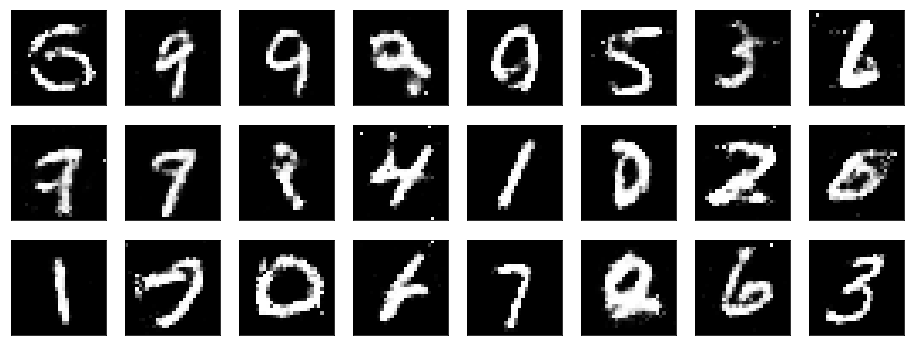

[61/80] 14.8s - g_loss: 0.8593 - d_loss: 0.6607 - d_acc: 0.5911
[62/80] 14.7s - g_loss: 0.8585 - d_loss: 0.6597 - d_acc: 0.5933
[63/80] 14.7s - g_loss: 0.8610 - d_loss: 0.6605 - d_acc: 0.5916
[64/80] 15.1s - g_loss: 0.8594 - d_loss: 0.6602 - d_acc: 0.5925
[65/80] 14.7s - g_loss: 0.8646 - d_loss: 0.6585 - d_acc: 0.5946
[66/80] 14.8s - g_loss: 0.8654 - d_loss: 0.6583 - d_acc: 0.5948
[67/80] 15.2s - g_loss: 0.8626 - d_loss: 0.6594 - d_acc: 0.5954
[68/80] 15.3s - g_loss: 0.8633 - d_loss: 0.6592 - d_acc: 0.5933
[69/80] 15.1s - g_loss: 0.8636 - d_loss: 0.6581 - d_acc: 0.5956
[70/80] 15.2s - g_loss: 0.8664 - d_loss: 0.6593 - d_acc: 0.5948
[71/80] 15.2s - g_loss: 0.8627 - d_loss: 0.6586 - d_acc: 0.5957
[72/80] 15.3s - g_loss: 0.8681 - d_loss: 0.6581 - d_acc: 0.5949
[73/80] 15.2s - g_loss: 0.8672 - d_loss: 0.6581 - d_acc: 0.5965
[74/80] 14.7s - g_loss: 0.8710 - d_loss: 0.6568 - d_acc: 0.5977
[75/80] 14.5s - g_loss: 0.8701 - d_loss: 0.6575 - d_acc: 0.5970
[76/80] 14.5s - g_loss: 0.8705 - d_loss:

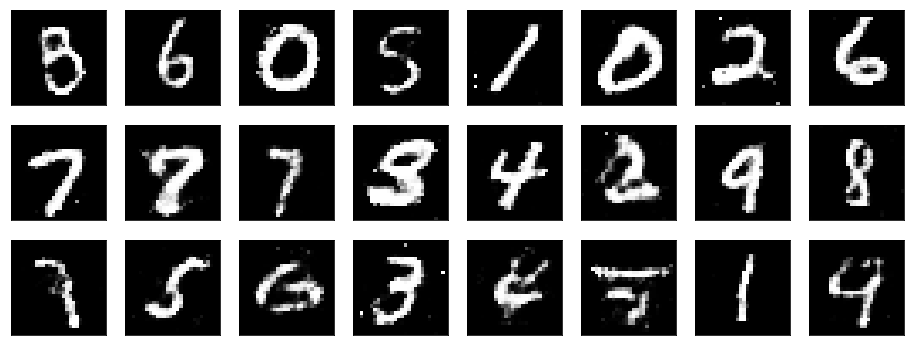

In [10]:
history = model.fit(data_loader, epochs=80)

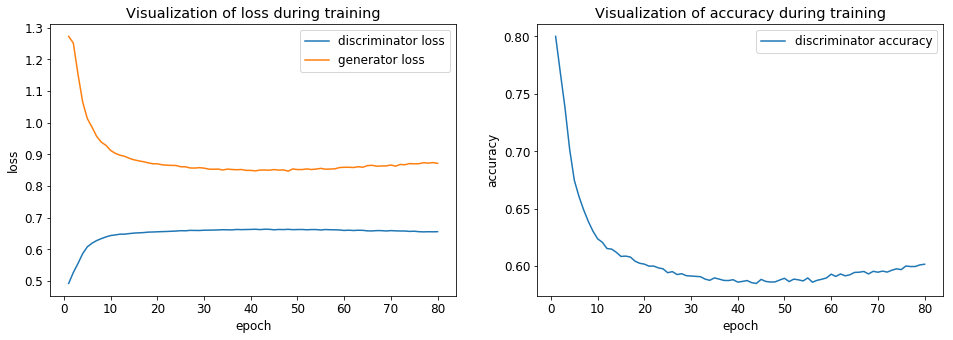

In [11]:
plot_history(history)